In [1]:
# AUTOR: DANIEL SOUZA LIMA 15 de setembro de 2021
#tradução do código em .c feito pelo Prof. Dr. Lucas Nicolao

#/* **************************************************************************************
#Algortimo básico simulação dinâmica molecular no ensemble NVE.
#Potencial de pares de Lennard-Jones em D=3, levando em conta todos pares.

# Parâmetros da simulação: temperatura, densidade (rho), passo de tempo
#(dt), número de partículas (N), dimensão do sistema (D)

# Descrições das funções:
#1) force(double r[][D], double a[][D])
#- calcula a força resultante em cada partícula/direção cartesiana, e armazena em 'a'
#2) vverlet(double r[][D], double v[][D], double a[][D])
#- atualização das posições 'r' e velocidades 'v' de acordo com velocity Verlet
#- devolve o valor da energia potencial por partícula
#3) measures(double r[][D], double v[][D], double *energia, double *temp, double *pressao)
#- mede energia total por partícula, temperatura cinética e pressão virial
#- lembrando que 3*temp/2 = energia cinética e energia - 3*temp/2 = energia potencial
#4) double energiacin(double v[][D])
#- devolve energia cinética por partícula
#5) overrelax(double r[][D], double a[][D])
#- suaviza forças de uma condição inicial aleatórias segundo dr/dt = -grad U
#6) initial3D(double r[][D], double v[][D], int qual)
#- condições iniciais aleatórias (qual=0) e cristal cúbico (qual=1) para posições
#- velocidades aleatórias de acordo com parâmetro temperatura
#7) reescalavT(double v[][D], double Talvo)
#- rescala velocidades para atingir temperatura alvo Talvo
#8) reescalarRho(double r[][D], double rho_alvo)
#- reescala posições, tamanho da caixa e densidade para mudar densidade para rho_alvo
#9) printXYZ(double r[][D])
#- imprime (na tela) configurações p/ compor arquivo xyz. 1a partícula cor diferente.
#************************************************************************************** */

import matplotlib.pyplot as plt
import numpy as np
import math
import random

global temperatura, rho, dt, N, D, L, V

temperatura = (1.0)
rho = (0.80)

dt = (0.001)

N = int(100)
D = int(3)

L = pow((N)/rho, 1.0/(D))
V = pow(L, (D))

print("Hello, world!")


def force(r, a):

    a = np.zeros((N, D))
    dr = np.zeros(D)
    en = 0

    for i in range(0, N-1):
        for j in range(i + 1, N):

            d2 = 0
            for n in range(0, D):
                dr[n] = r[i, n] - r[j, n]
                dr[n] = dr[n] - L * math.floor(dr[n] / L + 0.5)
                d2 += pow(dr[n], 2)

            r2 = 1.0 / d2
            r6 = pow(r2, 3)
            ff = 48.0 * r2 * r6 * (r6 - 0.5)

            for n in range(0, D):
                a[i, n] += ff*dr[n]
                a[j, n] -= ff*dr[n]
            en += 4.0 * r6 * (r6 - 1.0)

    return a, en / N


def vverlet(r, v, a):

    energia = 0
    a, energia = force(r, a)
    for i in range(0, N):
        for n in range(0, D):
            v[i, n] += 0.5*dt*a[i, n]
            r[i, n] += dt*v[i, n]

    a, energia = force(r, a)
    for i in range(0, N):
        for n in range(0, D):
            v[i, n] += 0.5*dt*a[i, n]

    return r, v, a


def measures(r, v, energia, temp, pressao):
    dr = np.zeros(D)
    d2 = 0
    r2 = 0
    r6 = 0
    ff = 0
    virial = 0.
    sumv2 = 0.
    en = 0

    for i in range(0, N - 1):

        for n in range(0, D):
            sumv2 += v[i, n] * v[i, n]

        for j in range(i + 1, N):
            d2 = 0
            for n in range(0, D):
                dr[n] = r[i, n] - r[j, n]
                dr[n] = dr[n] - L * math.floor((dr[n] / L) + 0.5)
                d2 += pow(dr[n], 2)
            r2 = 1.0 / d2
            r6 = pow(r2, 3)
            ff = 48.0 * r2 * r6 * (r6 - 0.5)

            for n in range(0, D):
                virial += ff * dr[n] * dr[n]
            en += 4.0 * r6 * (r6 - 1.0)

    for n in range(0, D):
        sumv2 += v[N - 1, n] * v[N-1, n]

    energia = sumv2 / (2.0 * (N)) + (en / (N))
    temp = sumv2 / ((D) * (N))
    pressao = temp * rho + virial / ((V) * (D))

    return r, v, energia, temp, pressao


def energiacin(v):
    K = 0.0

    for i in range(0, N):
        for n in range(0, D):
            K += v[i, n] * v[i, n]

    return K / (2.0 * N)


def overrelax(r, a):

    Dt = 0.1
    energia = 0.0

    a, energia = force(r, a)
    for i in range(0, N):
        norma = 0.0
        for n in range(0, D):
            norma += pow(a[i, n], 2)
        norma = math.sqrt(norma)
        for n in range(0, D):
            r[i, n] += Dt * a[i, n] / norma

    return


def initial3D(r, v, qual):

    somav2 = 0
    somav = np.zeros(D)

    if qual == 1:
        Nsites = int(round(pow(N, 1.0 / D)))
        dx = L / (Nsites)
        for i in range(0, Nsites):
            for j in range(0, Nsites):
                for k in range(0, Nsites):
                    ii = k + Nsites * (j + i * Nsites)
                    if ii < N:
                        r[ii, 0] = (i + 0.5) * dx
                        r[ii, 1] = (j + 0.5) * dx
                        r[ii, 2] = (k + 0.5) * dx
    else:
        for i in range(0, N):
            for n in range(0, D):
                r[i, n] = random.random() * L

    for i in range(0, N):
        for n in range(0, D):
            v[i, n] = random.random() - 0.5
            somav[n] += v[i, n]
            somav2 += math.pow(v[i, n], 2)

    for n in range(0, D):
        somav[n] /= N
    somav2 /= N
    fac = math.sqrt(D * temperatura / somav2)
    for i in range(0, N):
        for n in range(0, D):
            v[i, n] = (v[i, n] - somav[n]) * fac

    return v


def reescalavT(v, Talvo):
    temp = 0
    somav2 = 0

    for i in range(0, N):
        for n in range(0, D):
            somav2 += pow(v[i, n], 2)

    somav2 /= N
    temp = somav2 / D
    fac = math.sqrt(Talvo / temp)
    for i in range(0, N):
        for n in range(0, D):
            v[i, n] *= fac

    return v


def reescalarRho(r, rho_alvo):

    fac = pow(rho / rho_alvo, 1.0 / D)

    for i in range(0, N):
        for n in range(0, D):
            r[i, n] *= fac
    rho = rho_alvo

    return rho


def printXYZ(r):

    print(str(N) + "\n\n")
    for i in range(0, N):
        if i == 0:
            aux = 'B'
        else:
            aux = 'A'
        print(str(aux))
        for n in range(0, D):
            print(str(r[i][n] - L * math.floor(r[i][n]/L + 0.5) + L/2.) + "\n")


#Impressora para o OVITO
def impressora_video(r, N, tempo):
    
    buffer = "ITEM: TIMESTEP\n" + str(tempo) + "\n" + "ITEM: NUMBER OF ATOMS\n" + str(N) + "\n" + "ITEM: BOX BOUNDS ss ss pp\n" 
    buffer += "-1" + " " + "1\n" + "-1" + " " +  "1\n"
    buffer += "-1" + " " + "1\n" + "ITEM: ATOMS id x y z" + "\n"

    with open("particles.dump", 'a') as file_object:
        file_object.write(buffer)
        for i in range(N):
            buffer2 = str(int(i)) + "\t" +  str(round(r[i,0],3)) + "\t" + str(round(r[i,1],3)) + "\t" + str(round(r[i,2],3)) + "\n"
            file_object.write(buffer2)


#Lê as condições iniciais --------------- COMENTE A CHAMADA da FUNÇÃO "initi3D" SE FOR USÁ-lA
def ler_CondicoesIniciais(nome_do_arquivo):

    with open(nome_do_arquivo, "r") as file_object:
        dados = np.loadtxt(file_object)

    N = dados.shape[0]
    r = np.zeros((dados.shape[0],int(dados.shape[1]/2)))
    v = np.zeros((dados.shape[0],int(dados.shape[1]/2)))

    r = dados[:,0:3]
    v = dados[:,3:6]
    
    return r, v, N

# Começo do programa

r = np.zeros((N, D))
v = np.zeros((N, D))
a = np.zeros((N, D))

K = 0.0
U = 0.0
E = 0.0
T = 0.0
P = 0.0

#Condição inicial aleatória
initial3D(r, v, 0) 
K = energiacin(v)

#Condição inicial espicificada a partir do arquivo "condicoes_iniciais.dat"
#no formato x y z vx vy vz em que cada linha coresponde a uma partícula
#r, v, N = ler_CondicoesIniciais("condicoes_iniciais.dat")

for t in range(0, 5 * N):
    overrelax(r, a)
    a, U = force(r, a)
    if U <= 0:
        break





Hello, world!


In [2]:
def MB_speed(v,m,T):
    """ Maxwell-Boltzmann speed distribution for speeds """
    #kB = 1.38e-23
    kB = 1
    return (m/(2*np.pi*kB*T))**1.5 * 4*np.pi * v**2 * np.exp(-m*v**2/(2*kB*T))

In [3]:
EE = []
TT = []
KK = []
UU = []
PP = []
for t in range(0, 1000):
    r, v, a = vverlet(r, v, a)
    
    r, v, E, T, P = measures(r, v, E, T, P)

    #if t%50 == 0: 
    #  reescalavT(v, 2)

    K = 3.0 * T / 2.0
    U = E - K
    EE.append(E)    
    TT.append(T)
    KK.append(K)
    UU.append(U)
    PP.append(P)
    print(str(t) + " " + str(round(K, 6)) + " " + str(round(U, 6)) + " " + str(round(E, 6)) + " " + str(round(T, 6)) + " " + str(round(P, 6)))
    #impressora_video(r, N, t)


0 1.532159 -0.621366 0.910793 1.021439 21.012641
1 1.623234 -0.712729 0.910505 1.082156 20.740101
2 1.743656 -0.833537 0.910119 1.162437 20.380167
3 1.887247 -0.97756 0.909688 1.258165 19.95075
4 2.047006 -1.137743 0.909263 1.364671 19.472163
5 2.215895 -1.307007 0.908888 1.477263 18.964872
6 2.387482 -1.478896 0.908586 1.591655 18.447656
7 2.556354 -1.647989 0.908365 1.704236 17.936423
8 2.718284 -1.810062 0.908222 1.812189 17.443713
9 2.870221 -1.962076 0.908145 1.913481 16.978727
10 3.010151 -2.10203 0.908121 2.006767 16.547694
11 3.136907 -2.228773 0.908134 2.091271 16.154395
12 3.249983 -2.341807 0.908176 2.166656 15.800697
13 3.349353 -2.441119 0.908234 2.232902 15.487035
14 3.435326 -2.527025 0.908301 2.290218 15.212826
15 3.508451 -2.600077 0.908374 2.338967 14.976759
16 3.569426 -2.660977 0.908449 2.379617 14.777025
17 3.61905 -2.710527 0.908524 2.4127 14.611479
18 3.658189 -2.749591 0.908597 2.438792 14.477742
19 3.687739 -2.77907 0.908669 2.458493 14.373286
20 3.708622 -2.79

No handles with labels found to put in legend.


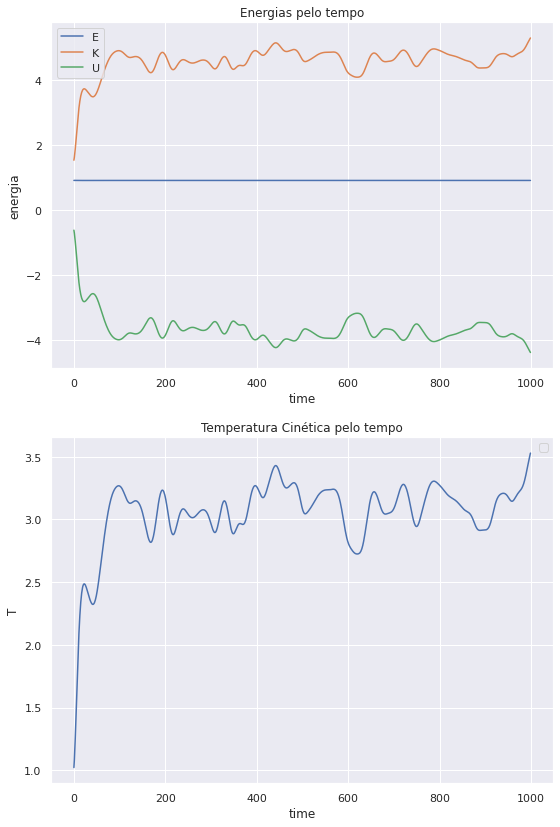

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
fig, ax = plt.subplots(2,1, figsize=(9,14))


ax[0].plot(EE, label='E')
ax[0].plot(KK, label='K')
ax[0].plot(UU, label='U')

ax[0].set(xlabel='time', ylabel='energia', title='Energias pelo tempo' )
ax[0].legend()

ax[1].plot(TT)
ax[1].set(xlabel='time', ylabel='T', title='Temperatura Cinética pelo tempo' )
ax[1].legend()
#
#ax[2].plot(temps, Tcv, label='Monte Carlo')
#ax[2].plot(df['T'],df['cv'],  label='Exata')
#ax[2].set(xlabel='T', ylabel='$c_v$', title='Calor Específico por spin' )
#ax[2].legend()
#
#ax[3].plot(temps, Tx, label='Monte Carlo')
#ax[3].plot(df['T'],df['x'], label='Exata')
#ax[3].set(xlabel='T', ylabel='$\chi$', title='Susceptibilidade magnética por spin' )
#ax[3].legend()
#

plt.savefig("Tarefa12_1.pdf")

In [5]:
EE2 = []
TT2 = []
KK2 = []
UU2 = []
PP2 = []
tf = 1000
teq = 400
vv = 0
for t in range(0, tf):
    r, v, a = vverlet(r, v, a)
    
    r, v, E, T, P = measures(r, v, E, T, P)

    if t%30 == 0: 
      reescalavT(v, 1)
      print(str(t) + " " + str(round(K, 6)) + " " + str(round(U, 6)) + " " + str(round(E, 6)) + " " + str(round(T, 6)) + " " + str(round(P, 6)))


    if t > teq:
      vv += np.sqrt(v[:,0]**2 + v[:,1]**2 + v[:,2]**2)
    
    K = 3.0 * T / 2.0
    U = E - K
    EE2.append(E)    
    TT2.append(T)
    KK2.append(K)
    UU2.append(U)
    PP2.append(P)
v3 = vv/(tf-teq)


0 5.292788 -4.383459 0.909319 3.542866 7.281385
30 1.939993 -4.845076 -2.905081 1.299596 3.714785
60 1.679618 -5.034085 -3.354468 1.122859 2.786513
90 1.523747 -5.062519 -3.53877 1.012871 2.601816
120 1.433349 -4.991391 -3.558044 0.957962 2.734128
150 1.644782 -5.139775 -3.494994 1.099967 2.149302
180 1.60406 -5.249022 -3.644961 1.06941 1.609481
210 1.496303 -5.245352 -3.74905 0.999088 1.466788
240 1.556354 -5.304063 -3.747707 1.037048 1.252139
270 1.465134 -5.268408 -3.803275 0.976213 1.37728
300 1.4133 -5.180893 -3.767592 0.938965 1.792477
330 1.408031 -5.084055 -3.676025 0.938903 2.207214
360 1.603112 -5.187518 -3.584407 1.071455 1.924091
390 1.487822 -5.179409 -3.691584 0.988621 1.936159
420 1.432255 -5.106756 -3.674502 0.955751 2.177382
450 1.536347 -5.144476 -3.608129 1.025175 2.100192
480 1.562262 -5.208167 -3.645905 1.042444 1.872993
510 1.477681 -5.187244 -3.70956 0.983619 1.904712
540 1.467927 -5.152935 -3.685006 0.977037 2.032828
570 1.476423 -5.126951 -3.650528 0.986718 2.0

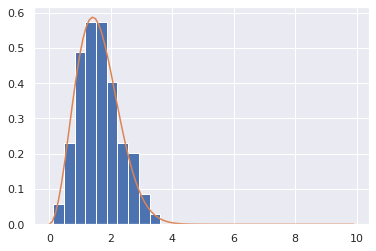

In [6]:
vs = np.arange(0,10,0.1)
max = MB_speed(vs,1,1)

v3 = np.sqrt(v[:,0]**2 + v[:,1]**2 + v[:,2]**2)
plt.hist(v3, density=True)
plt.plot(vs, max)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


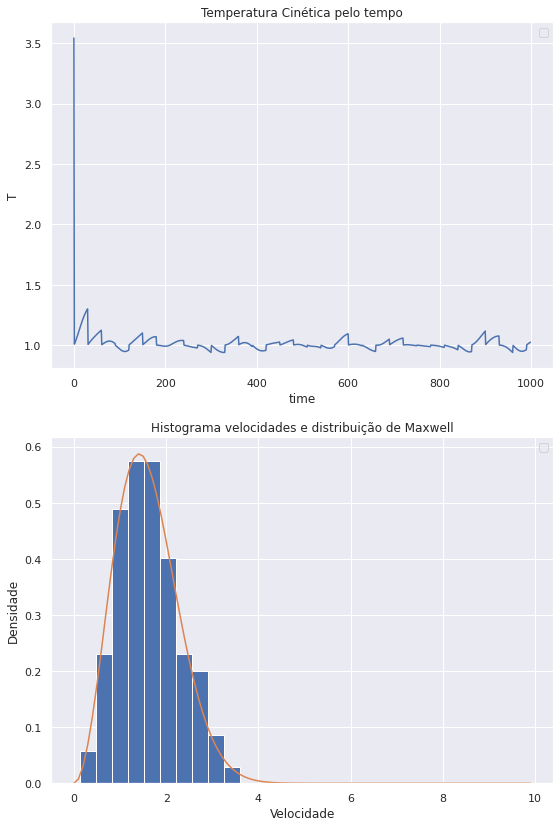

In [7]:

fig, ax = plt.subplots(2,1, figsize=(9,14))


ax[0].plot(TT2)
ax[0].set(xlabel='time', ylabel='T', title='Temperatura Cinética pelo tempo' )
ax[0].legend()

v3 = np.sqrt(v[:,0]**2 + v[:,1]**2 + v[:,2]**2)

ax[1].hist(v3, density=True)
ax[1].plot(vs, max)
ax[1].set(xlabel='Velocidade', ylabel='Densidade', title='Histograma velocidades e distribuição de Maxwell' )
ax[1].legend()
#
#ax[2].plot(temps, Tcv, label='Monte Carlo')
#ax[2].plot(df['T'],df['cv'],  label='Exata')
#ax[2].set(xlabel='T', ylabel='$c_v$', title='Calor Específico por spin' )
#ax[2].legend()
#
#ax[3].plot(temps, Tx, label='Monte Carlo')
#ax[3].plot(df['T'],df['x'], label='Exata')
#ax[3].set(xlabel='T', ylabel='$\chi$', title='Susceptibilidade magnética por spin' )
#ax[3].legend()
#

plt.savefig("Tarefa12_2.pdf")